### IMPORT LIBRARIES AND IMPORTANT VARIABLES

In [1]:
import os
import shutil
import random
import hashlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

import warnings
warnings.filterwarnings("ignore", 
                        category = FutureWarning)

print("Libraries imported successfully.")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Libraries imported successfully.
Num GPUs Available: 1


In [2]:
DATASET_PATH = "./Dataset_2/A_23"

### READ IMAGES

In [3]:
def read_images(dataset_path, image_extensions = (".jpg", ".jpeg", ".png")):
    image_files = []
    total_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            total_files.append(os.path.normpath(os.path.join(root, file)))
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.normpath(os.path.join(root, file)))
    
    print(f"Total image read: {len(image_files)}")
    print(f"Total files read: {len(total_files)}")

    return image_files

In [4]:
image_files = read_images(DATASET_PATH)

Total image read: 1074
Total files read: 1074


> Based on the output above, it's known that the data from the *A_23* folder has been successfully read, with a total of 1074 images.

### EXPLORATORY DATA ANALYSIS

#### DISPLAY RANDOM IMAGE

In [5]:
def view_random_image(file_list, n):
    n = min(n, len(file_list))
    random_image = random.sample(file_list, n)
    cols = min(n, 5)
    rows = (n + cols - 1) // cols
    plt.figure(figsize = (4 * cols, 4 * rows))
    for i in range(0, n): 
        plt.subplot(rows, cols, i+1)
        img = mpimg.imread(random_image[i])
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

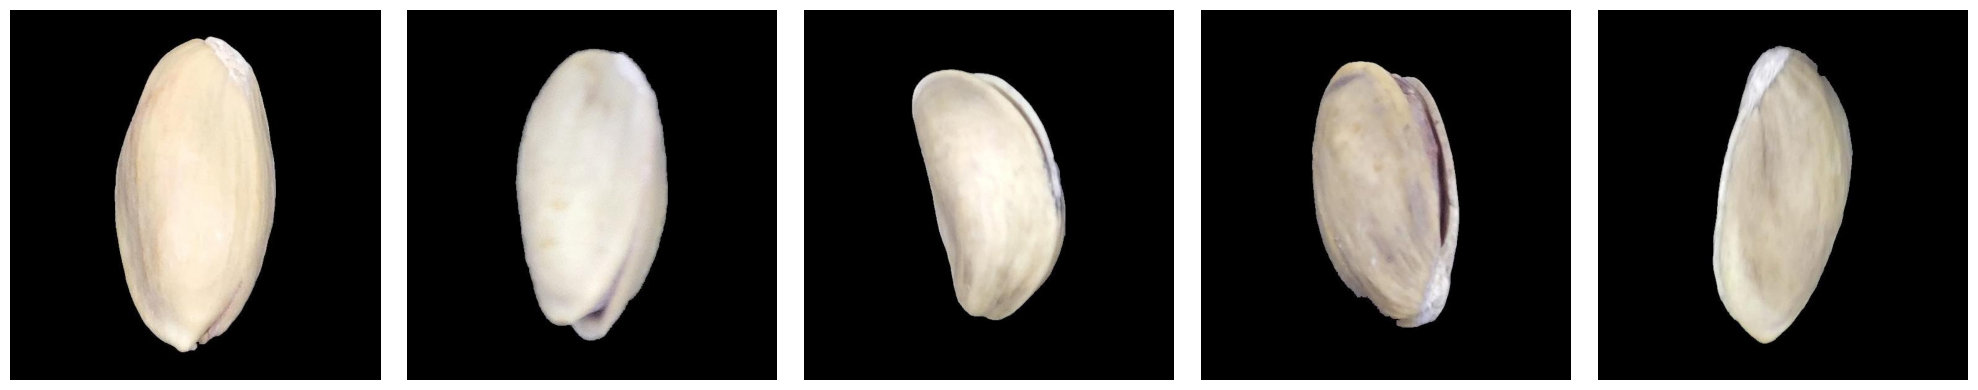

In [6]:
view_random_image(image_files, 5)

> Based on the output above, the *A_23* data has been successfully read.

#### CHECK CORRUPTED IMAGES

In [7]:
def check_corrupted(file_list):
    corrupted = []
    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                img.verify()
        except Exception as e:
            print(f"Corrupted: {norm_path} ({e})")
            corrupted.append(norm_path)

    print(f"Total corrupted images found: {len(corrupted)}")
    return corrupted

In [8]:
corrupted = check_corrupted(image_files)

Total corrupted images found: 0


> Based on the output above, the *A_23* folder has no corrupted images, so the exploration can continue.

#### CHECK DUPLICATED IMAGES

In [9]:
def check_duplicated(file_list):
    hashes = {}
    duplicated = []

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with open(norm_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicated.append((norm_path, hashes[file_hash]))
            else:
                hashes[file_hash] = norm_path
        except Exception as e:
            print(f"Error reading {norm_path}: {e}")

    print(f"Total duplicates found: {len(duplicated)}")
    return duplicated

In [10]:
def view_duplicated(duplicated_image):
    all_paths = []
    labels = []
    for dup, ori in duplicated_image:
        all_paths.append(os.path.normpath(ori))
        labels.append("Original")
        all_paths.append(os.path.normpath(dup))
        labels.append("Duplicate")

    total = len(all_paths)
    cols = 2
    rows = len(duplicated_image)

    plt.figure(figsize = (10, 4 * rows))
    for i, (path, label) in enumerate(zip(all_paths, labels)):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(path)
        plt.imshow(img)
        plt.title(f"{label}\n{path}",
                  fontsize = 9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
duplicated = check_duplicated(image_files)

Total duplicates found: 0


In [12]:
view_duplicated(duplicated)

<Figure size 1000x0 with 0 Axes>

> Based on the output above, it is known that there are no duplicated images in the *A_23* folder.

#### CHECK IMAGE RESOLUTIONS

In [13]:
def check_resolution(file_list):
    resolution_map = {}
    counter = {}

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                res = img.size

                if res not in resolution_map:
                    resolution_map[res] = []
                resolution_map[res].append(norm_path)

                if res in counter:
                    counter[res] += 1
                else:
                    counter[res] = 1
        except Exception as e:
            print(f"Failed to read {norm_path}: {e}")

    print(f"Total images checked: {sum(counter.values())}")
    print(f"Unique resolutions found: {len(counter)}")

    print("List of unique resolutions:")
    for res in sorted(counter.keys()):
        print(f" - {res[0]}x{res[1]} ({counter[res]} images)")

    return counter, resolution_map

In [14]:
res_counter, res_map = check_resolution(image_files)

Total images checked: 1074
Unique resolutions found: 1
List of unique resolutions:
 - 600x600 (1074 images)


> Based on the output above, it is known that there is 1 type of unique image resolution in the *A_23* folder, which is 600x600 pixels. This resolution consistency indicates that all images have uniform dimensions, thus no further image transformation or resizing is required in the preprocessing stage.

#### CHECK UNIQUE ASPECT RATIO

In [15]:
def check_aspect_ratio(file_list, show_plot = True):
    aspect_ratios = []

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                w, h = img.size
                if h != 0:
                    aspect_ratios.append(w / h)
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")

    if show_plot:
        plt.figure(figsize = (8, 4))
        plt.hist(aspect_ratios, bins = 30, color = "#097969", edgecolor = "black")
        plt.title("Aspect Ratio Distribution")
        plt.xlabel("Aspect Ratio (Width / Height)")
        plt.ylabel("Image Count")
        plt.tight_layout()
        plt.show()

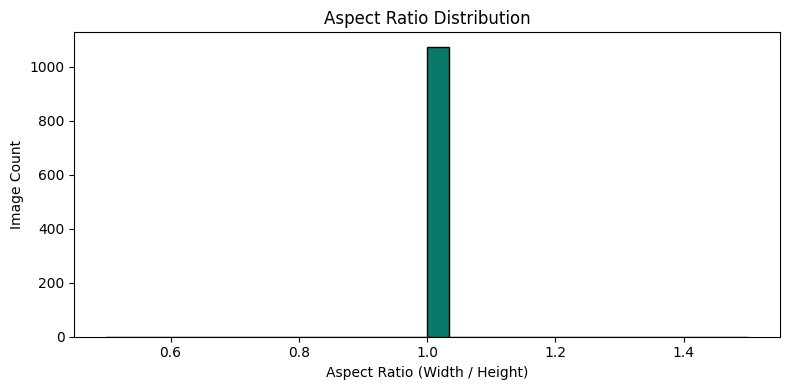

In [16]:
check_aspect_ratio(image_files)

> In line with the check image resolutions results, it was found that the aspect ratio of all images in the *A_23* folder is also uniform, which is 1.0 (calculated from 600/600). This aspect ratio value indicates that all images are square-shaped, so no proportion adjustment process is required.

#### CHECK UNIQUE DATA TYPES

In [17]:
def check_unique_datatypes(file_list):
    dtypes = set()
    dtype_map = {}

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                arr = np.array(img)
                dtype = str(arr.dtype)
                dtypes.add(dtype)

                if dtype not in dtype_map:
                    dtype_map[dtype] = []
                dtype_map[dtype].append(norm_path)
        except Exception as e:
            print(f"Failed to read {norm_path}: {e}")

    print(f"Unique data types: {len(dtypes)}")
    print(f"Data types: {sorted(dtypes)}")
    return dtypes, dtype_map

In [18]:
dtypes, dtype_map = check_unique_datatypes(image_files)

Unique data types: 1
Data types: ['uint8']


> Based on the output above, it is known that all images in the *A_23* folder have 1 consistent data type, which is 'uint8'. This data type is a standard format for image representation, where pixels are in the range of 0-255. The consistency of this data type ensures that no additional conversion is required during preprocessing, and the images can be directly used in the model pipeline.

#### CHECK UNIQUE FILE TYPES

In [19]:
def check_unique_filetypes(file_list):
    formats = set()
    format_map = {}

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                fmt = img.format.upper()
                formats.add(fmt)

                if fmt not in format_map:
                    format_map[fmt] = []
                format_map[fmt].append(norm_path)
        except Exception as e:
            print(f"Failed to read {norm_path}: {e}")

    print(f"Unique file types: {len(formats)}")
    print(f"File types: {sorted(formats)}")
    return formats, format_map

In [20]:
formats, format_map = check_unique_filetypes(image_files)

Unique file types: 1
File types: ['JPEG']


> Based on the output above, it is known that the images in the *A_23* folder have 1 unique file type, which is 'JPEG'. This indicates that all images in the folder have a uniform file format, so no additional format conversion is required during the preprocessing or model pipeline.

#### CHECK UNIQUE NUMBER OF CHANNELS

In [21]:
def check_channels(file_list):
    channel_count = {}
    channel_map = {}

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                mode = img.mode
                num_channels = len(img.getbands())

                if num_channels not in channel_count:
                    channel_count[num_channels] = 0
                    channel_map[num_channels] = []
                channel_count[num_channels] += 1
                channel_map[num_channels].append(norm_path)
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")

    print(f"Number of unique channel counts: {len(channel_count)}")
    for ch, count in channel_count.items():
        print(f"{ch} Channels: {count} images")
    return channel_count, channel_map

In [22]:
channel_count, channel_map = check_channels(image_files)

Number of unique channel counts: 1
3 Channels: 1074 images


> Based on the output above, it is known that the number of unique channels in the *A_23* folder is only 1, which is images with 3 color channels (RGB). This indicates that all images have a uniform color format, so no channel conversion process is required during preprocessing.

#### CHECK BRIGHTNESS AND CONTRAST

In [23]:
def check_bright_contrast(file_list, show_plot = True):
    brightness = []
    contrast = []

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                img = img.convert("L")
                arr = np.array(img).astype(np.float32)

                b = np.mean(arr)
                brightness.append(b)

                c = np.std(arr)
                contrast.append(c)
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")

    print(f"Processed {len(brightness)} images.")
    print(f"Brightness range: {min(brightness):.2f} - {max(brightness):.2f}")
    print(f"Contrast range: {min(contrast):.2f} - {max(contrast):.2f}")

    if show_plot:
        mean_brightness = np.mean(brightness)
        mean_contrast = np.mean(contrast)
        
        plt.figure(figsize = (12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(brightness, bins = 30, color = "#097969", edgecolor = "black")
        plt.axvline(mean_brightness, color = "red", linestyle = "dashed", linewidth = 2, label = f"Mean: {mean_brightness:.2f}")
        plt.title("Brightness Distribution")
        plt.xlabel("Brightness (mean pixel value)")
        plt.ylabel("Image Count")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.hist(contrast, bins = 30, color = "#097969", edgecolor = "black")
        plt.axvline(mean_contrast, color = "red", linestyle = "dashed", linewidth = 2, label = f"Mean: {mean_contrast:.2f}")
        plt.title("Contrast Distribution")
        plt.xlabel("Contrast (pixel stdev)")
        plt.ylabel("Image Count")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return brightness, contrast

Processed 1074 images.
Brightness range: 21.05 - 72.27
Contrast range: 56.30 - 104.61


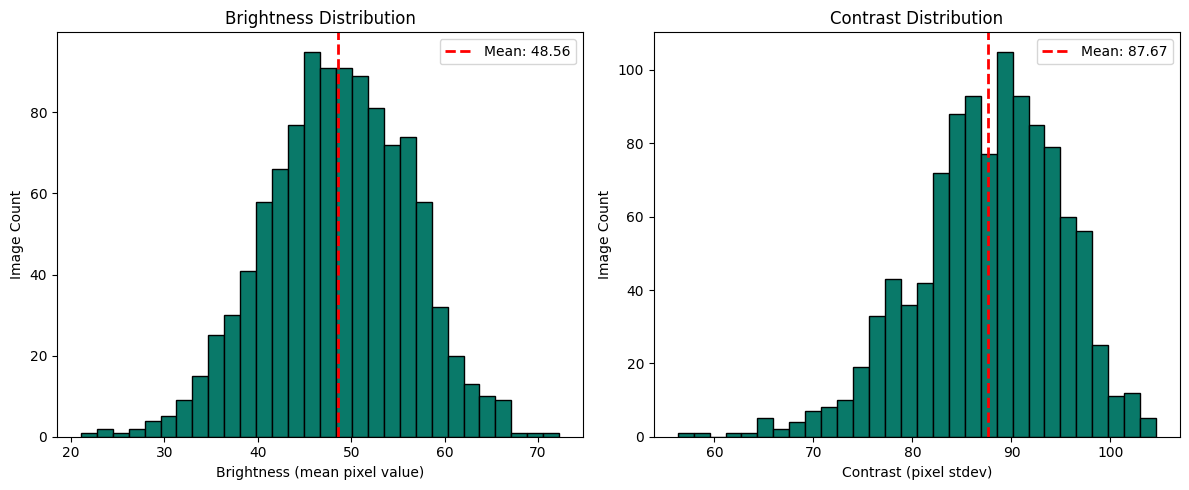

In [24]:
brightness, contrast = check_bright_contrast(image_files)

> Based on the output above, it is known that the brightness values range from 21.05 to 72.27, with an average of 48.56. This indicates that the majority of images have a fairly balanced level of brightness (neither too dark nor too bright), as shown by the distribution resembling a normal distribution in the graph. This signifies no extreme bias in image brightness.  
> Meanwhile, the contrast values are within the range of 56.30 - 104.61, with an average of 87.67. The right-skewed contrast distribution indicates that some images have higher contrast compared to the majority.  
> Overall, both brightness and contrast in the *A_23* folder are well-distributed and do not show any extreme outliers. Therefore, no comprehensive brightness or contrast adjustment is required in the preprocessing stage.

#### CHECK COLOR DISTRIBUTION

In [25]:
def check_color_distribution(file_list, show_plot = True, single_image = False):
    red_hist = np.zeros(256)
    green_hist = np.zeros(256)
    blue_hist = np.zeros(256)
    total_images = 0

    if single_image:
        file_list = file_list[:1]

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                img = img.convert("RGB")
                r, g, b = img.split()
                r_arr = np.array(r).flatten()
                g_arr = np.array(g).flatten()
                b_arr = np.array(b).flatten()

                red_hist += np.bincount(r_arr, minlength = 256)
                green_hist += np.bincount(g_arr, minlength = 256)
                blue_hist += np.bincount(b_arr, minlength = 256)

                total_images += 1
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")
    print(f"Processed {total_images} images.")

    if show_plot:
        red_mean = np.average(np.arange(256), weights = red_hist)
        green_mean = np.average(np.arange(256), weights = green_hist)
        blue_mean = np.average(np.arange(256), weights = blue_hist)
        
        plt.figure(figsize = (10, 15))

        plt.subplot(3, 1, 1)
        plt.bar(range(256), red_hist, color = "red")
        plt.axvline(red_mean, color = "black", linestyle = "dashed", linewidth = 2, label = f"Mean: {red_mean:.2f}")
        plt.title("Red Color Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.bar(range(256), green_hist, color = "green")
        plt.axvline(green_mean, color = "black", linestyle = "dashed", linewidth = 2, label = f"Mean: {green_mean:.2f}")
        plt.title("Green Color Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.bar(range(256), blue_hist, color = "blue")
        plt.axvline(blue_mean, color = "black", linestyle = "dashed", linewidth = 2, label = f"Mean: {blue_mean:.2f}")
        plt.title("Blue Color Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Processed 1 images.


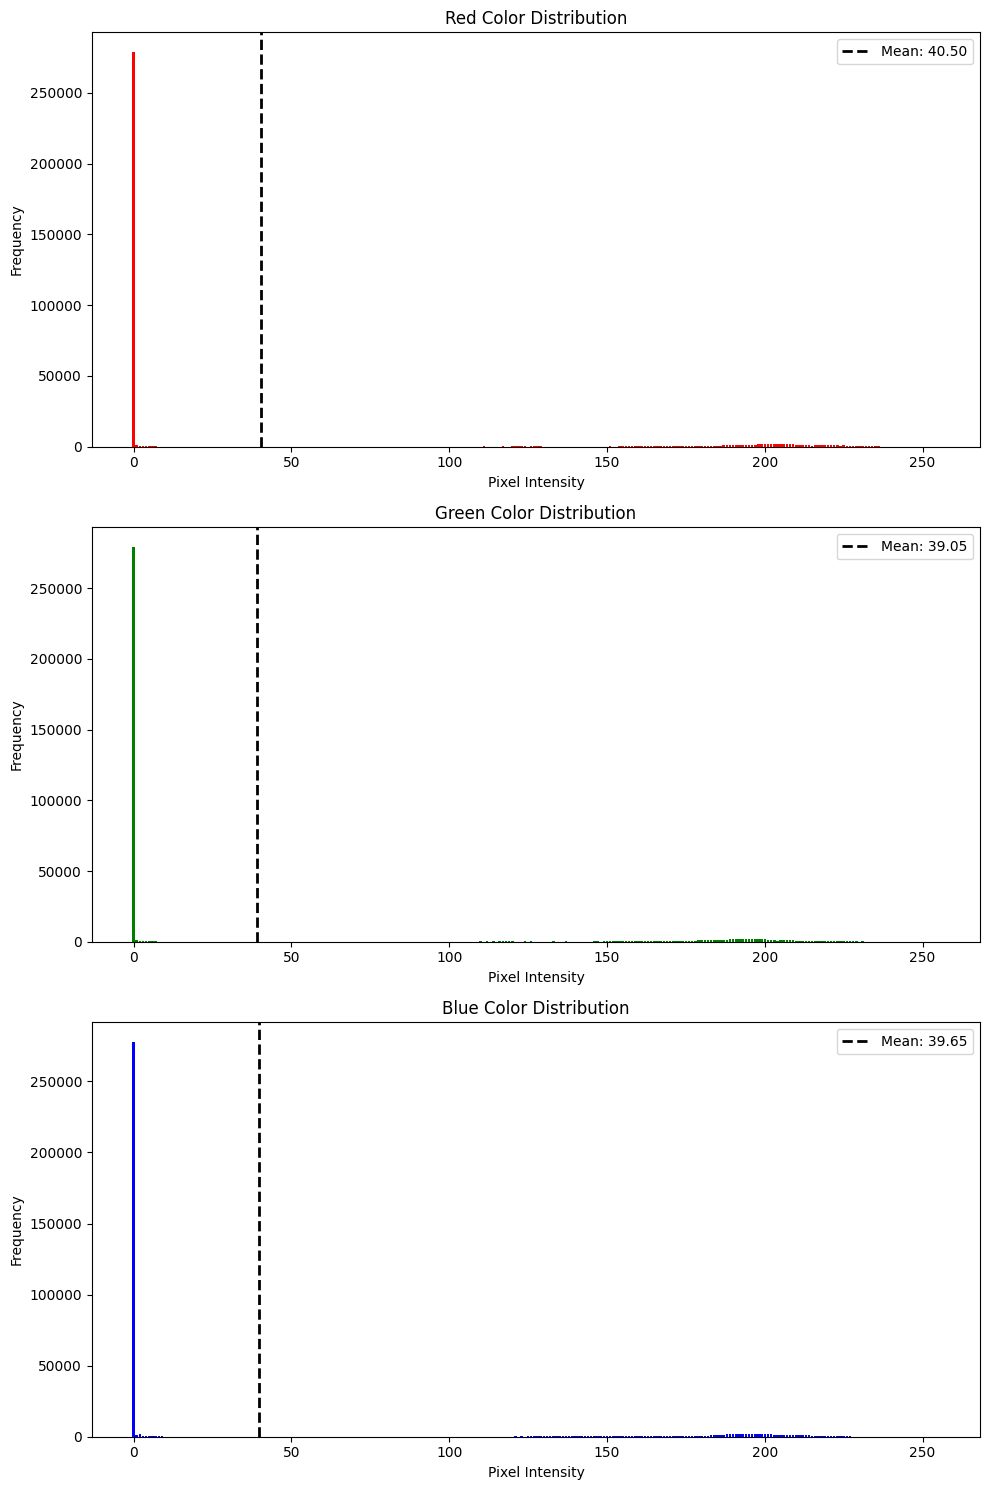

In [26]:
check_color_distribution(image_files, single_image = True)

> Based on the color distribution check for the single image above, it is shown that most pixel intensities are at low values (approaching 0) across all color channels. The average intensity value for each channel is approximately:
> - **RED**: 40.50
> - **GREEN**: 39.05
> - **BLUE**: 39.65
>
> This indicates that the image tends to be dark and has a dominance of black or shadowy colors, with little variation in bright colors.

Processed 1074 images.


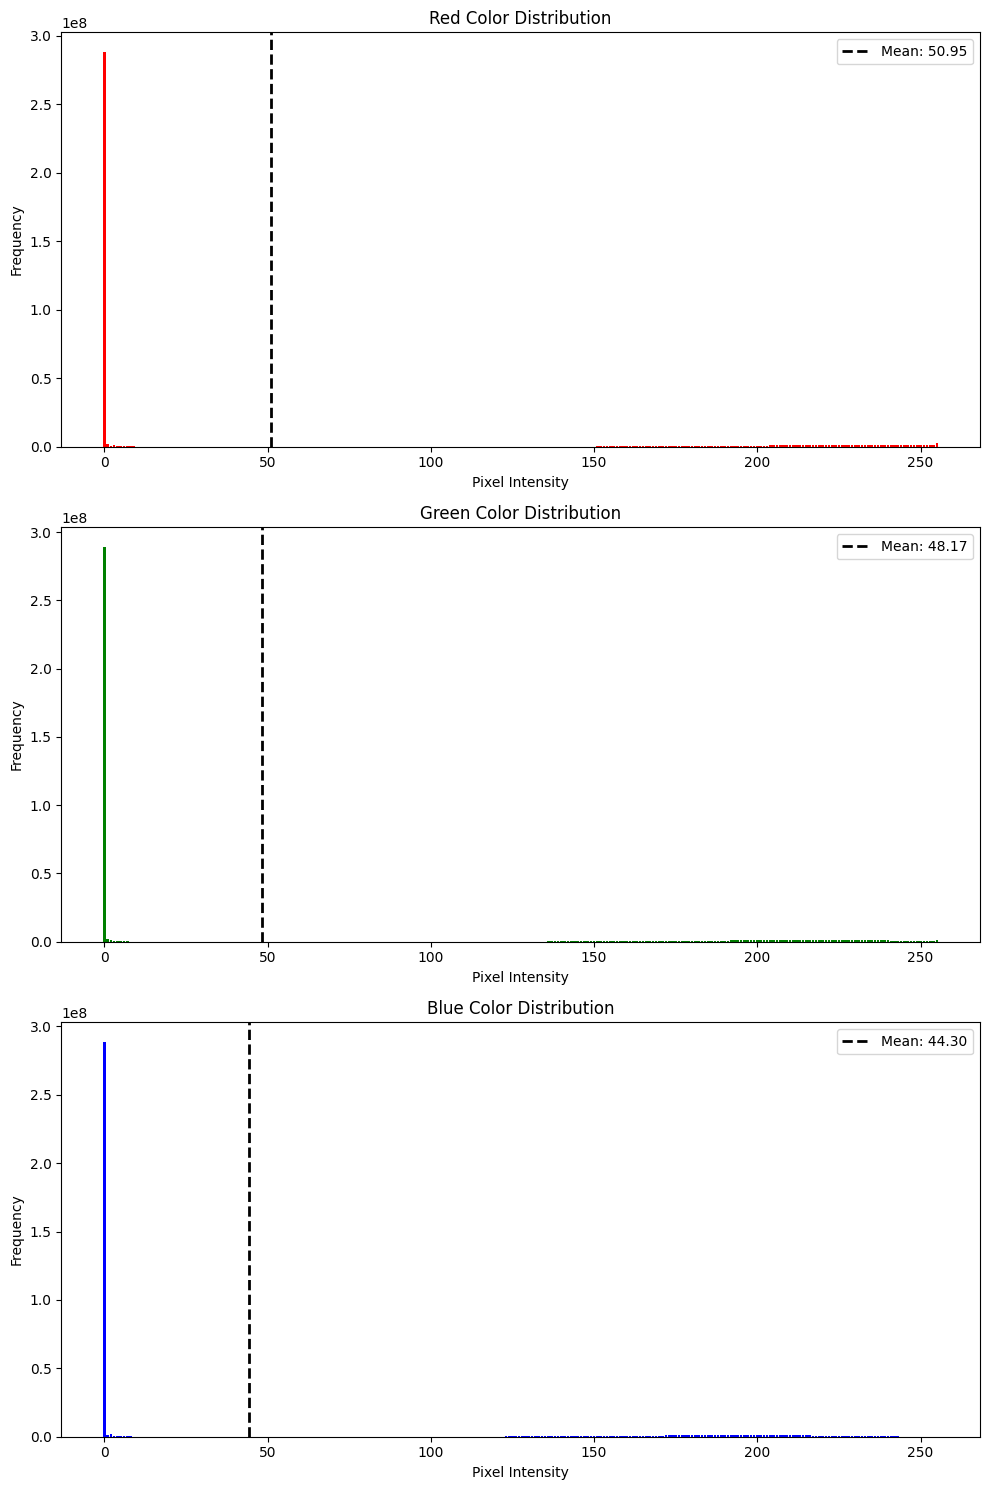

In [27]:
check_color_distribution(image_files)

> Based on the color distribution check for all images above, a similar pattern is observed: a dominance of low pixel intensities across all color channels. The average color intensity values for all images are:
> - **RED**: 50.95
> - **GREEN**: 48.17
> - **BLUE**: 44.30
>
> This indicates that most images in the *A_23* folder have a relatively dark color tone, with slight differences between the color channels, where the red channel is slightly more dominant than green and blue.  
> With these characteristics, it can be concluded that the images in the *A_23* folder have a color tendency that is not very bright and approaches a dark monochromatic tone.

#### CHECK SHARPNESS

In [5]:
def check_sharpness(file_list, show_plot = True, show_blurry = True, threshold = 100, max_images = 21):
    sharpness_scores = []
    blurry_images = []
    total_images = 0

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                img_gray = np.array(img.convert("L"))

            laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
            variance = laplacian.var()
            sharpness_scores.append(variance)
            total_images += 1

            if show_blurry and variance < threshold:
                blurry_images.append((norm_path, variance))
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")
    print(f"Processed {total_images} images.")
    if total_images == 0:
        return []

    print(f"Sharpness range: {min(sharpness_scores):.2f} - {max(sharpness_scores):.2f}")
    print(f"Mean sharpness: {np.mean(sharpness_scores):.2f}")

    if show_plot:
        mean_sharpness = np.mean(sharpness_scores)
        plt.figure(figsize = (8, 5))
        plt.hist(sharpness_scores, bins = 30, color = "#097969", edgecolor = "black")
        plt.axvline(mean_sharpness, color = "red", linestyle = "dashed", linewidth = 2, label = f"Mean: {mean_sharpness:.2f}")
        plt.title("Sharpness Distribution")
        plt.xlabel("Sharpness Score")
        plt.ylabel("Image Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if show_blurry and blurry_images:
        blurry_images.sort(key = lambda x: x[1])
        print(f"Found {len(blurry_images)} blurry images.")

        num_show = min(max_images, len(blurry_images))
        cols = 3
        rows = (num_show + cols - 1) // cols

        plt.figure(figsize = (4 * cols, 4 * rows))
        for idx, (img_path, sharpness) in enumerate(blurry_images[:num_show]):
            img = Image.open(img_path).convert("RGB")
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            plt.title(f"{os.path.basename(img_path)}\nSharpness: {sharpness:.2f}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return blurry_images

Processed 1074 images.
Sharpness range: 88.99 - 399.88
Mean sharpness: 174.30


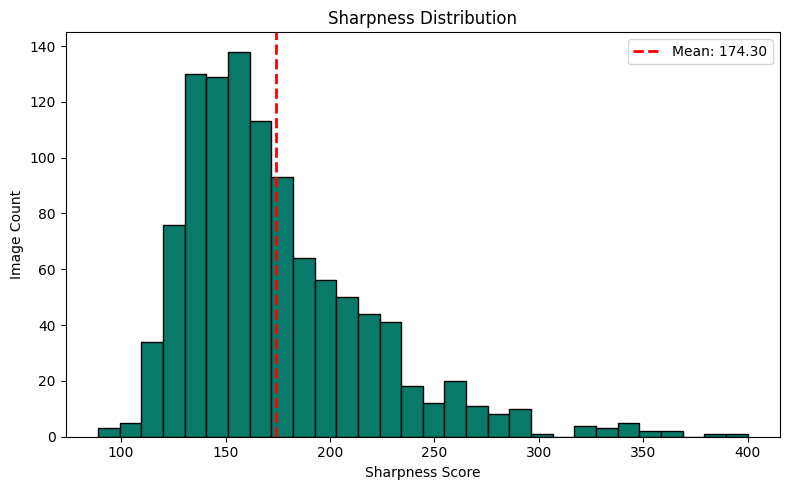

Found 3 blurry images.


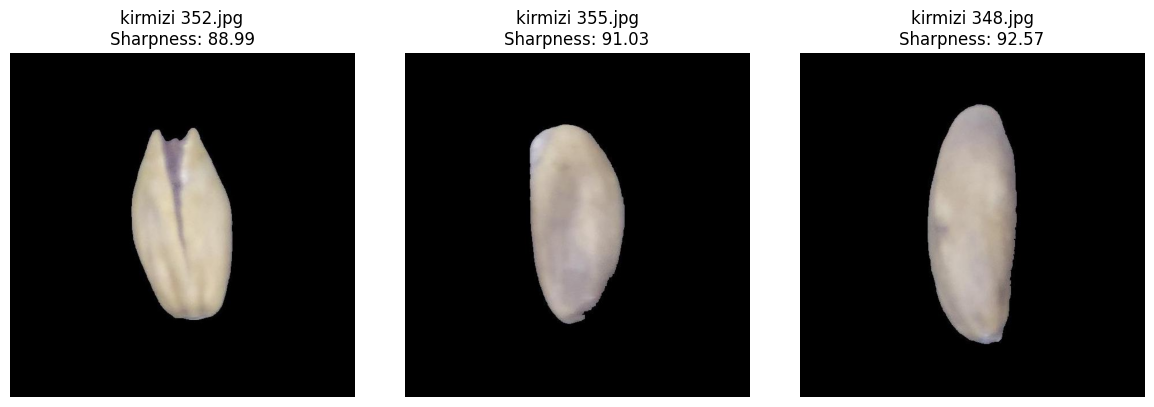

In [29]:
blurry_images = check_sharpness(image_files)

> Based on the sharpness check results above, it was found that the sharpness values range from 88.99 to 399.88, with an average of 174.30.  
> The distribution of sharpness values shows a slightly right-skewed shape. With a threshold of 100, 3 images were categorized as blurry:
> - **kirmizi 352.jpg** (*sharpness* 88.99)
> - **kirmizi 355.jpg** (*sharpness* 91.03)
> - **kirmizi 348.jpg** (*sharpness* 92.57)
>
> This indicates that only a small portion of the data has low image quality (blurry). Thus, the overall data is considered sharp and suitable for further processing.  
> Additionally, the 3 images detected as blurry will be processed in the preprocessing section.

#### CHECK GRAININESS

In [30]:
def check_graininess(file_list, show_plot = True, show_images = True, threshold = 15, max_images = 21):
    graininess_scores = []
    grainy_images = []
    total_images = 0

    for path in file_list:
        norm_path = os.path.normpath(path)
        try:
            with Image.open(norm_path) as img:
                gray = np.array(img.convert("L"))
            blurred = cv2.GaussianBlur(gray, (3, 3), 0)
            noise = cv2.absdiff(gray, blurred)
            graininess = np.std(noise)
            graininess_scores.append(graininess)
            total_images += 1

            if show_images and graininess >= threshold:
                grainy_images.append((norm_path, graininess))
        except Exception as e:
            print(f"Failed to process {norm_path}: {e}")

    print(f"Processed {total_images} images.")
    if total_images == 0:
        return []

    print(f"Graininess range: {min(graininess_scores):.2f} - {max(graininess_scores):.2f}")
    print(f"Mean graininess: {np.mean(graininess_scores):.2f}")

    if show_plot:
        mean_graininess = np.mean(graininess_scores)
        plt.figure(figsize = (8, 5))
        plt.hist(graininess_scores, bins = 30, color = "#097969", edgecolor = "black")
        plt.axvline(mean_graininess, color = "red", linestyle = "dashed", linewidth = 2, label = f"Mean: {mean_graininess:.2f}")
        plt.title("Graininess Distribution")
        plt.xlabel("Graininess")
        plt.ylabel("Image Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if show_images and grainy_images:
        grainy_images.sort(key = lambda x: x[1], reverse = True)
    print(f"Found {len(grainy_images)} grainy images.")
    num_show = min(max_images, len(grainy_images))
    cols = 3
    rows = (num_show + cols - 1) // cols

    plt.figure(figsize = (4 * cols, 4 * rows))
    for idx, (img_path, grain_score) in enumerate(grainy_images[:num_show]):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(f"{os.path.basename(img_path)}\nGraininess: {grain_score:.2f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return grainy_images

Processed 1074 images.
Graininess range: 1.98 - 4.10
Mean graininess: 2.69


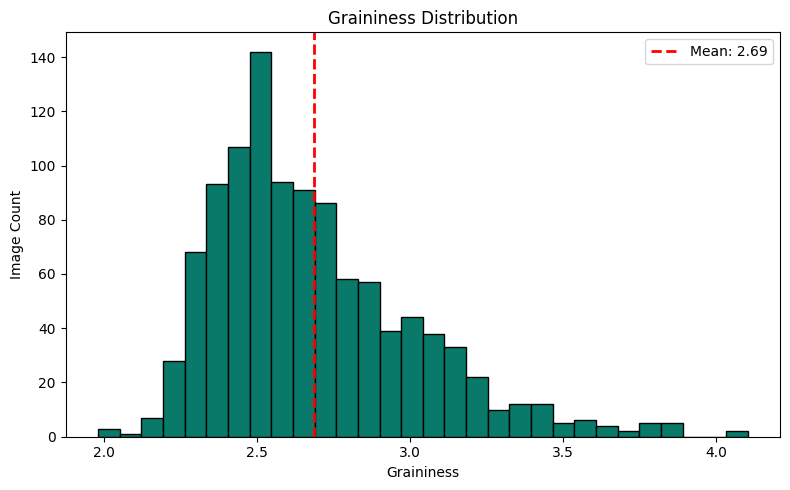

Found 0 grainy images.


<Figure size 1200x0 with 0 Axes>

In [31]:
grainy_images = check_graininess(image_files)

> Based on the graininess check results above, it was found that the graininess values (the level of visual noise in the image) are in the range of 1.98 - 4.10, with an average of 2.69.  
> The graininess distribution appears to resemble a slightly right-skewed normal distribution, with most images having a graininess level between 2.4 and 2.8.  
> With a grainy image detection threshold of 15, no images were found to exceed this value, so all images in the *A_23* folder can be categorized as free from significant visual noise.  
> Therefore, no further denoising process is required.

### PREPROCESSING

#### REMOVE BLURRY IMAGES

In [6]:
def remove_blurry_images(file_list, blurry_images):
    removed_files = []
    for path, sharpness in blurry_images:
        norm_path = os.path.normpath(path)
        try:
            os.remove(norm_path)
            removed_files.append(norm_path)
            if norm_path in file_list:
                file_list.remove(norm_path)
        except Exception as e:
            print(f"Failed to remove {norm_path}: {e}")
    print(f"Total blurry images removed: {len(removed_files)}")
    return file_list

Processed 1074 images.
Sharpness range: 88.99 - 399.88
Mean sharpness: 174.30
Found 3 blurry images.


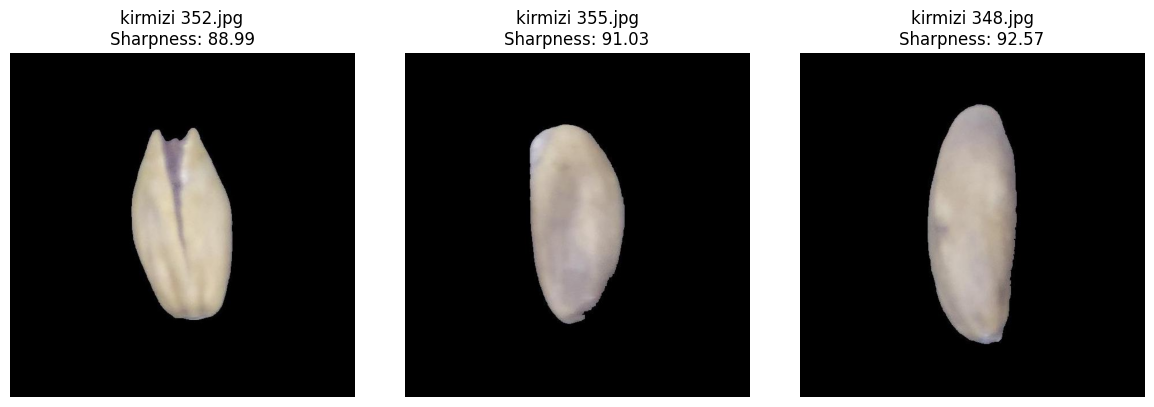

Total blurry images removed: 3


In [7]:
image_files = remove_blurry_images(image_files, check_sharpness(image_files, show_plot = False))

> Based on the output above, the blurry images identified in the previous EDA section have been removed from the data. This step is crucial because autoencoders heavily rely on their ability to precisely reconstruct image details. Blurry images tend to have missing or unclear details, which can interfere with the learning process of their latent representations.  
> By removing blurry images, the training process can focus more on sharp and consistent visual patterns, thereby improving the model's ability to accurately reconstruct the input and maintain the quality of the learned representative features.

### DATA SPLITTING

In [8]:
train_set, test_set = train_test_split(image_files, test_size = 0.2, random_state = SEED)
val_set, test_set = train_test_split(test_set, test_size = 0.5, random_state = SEED)

print(f"Data split: {len(train_set)} ({round(len(train_set)/len(image_files), 2)}) train, {len(val_set)} ({round(len(val_set)/len(image_files), 2)}) validation, {len(test_set)} ({round(len(test_set)/len(image_files), 2)}) test images.")

Data split: 856 (0.8) train, 107 (0.1) validation, 108 (0.1) test images.


> Based on the output above, the image data has been successfully split with an 80:10:10 ratio.

### RESIZE IMAGES

In [9]:
def resize_sets(data_sets, save_to, target_size = (224, 224)):
    for set_name, file_list in data_sets.items():
        if not file_list:
            print(f"Cannot process {set_name}.")
            continue
        dest_folder = os.path.join(save_to, set_name)
        os.makedirs(dest_folder, exist_ok = True)

        for path in file_list:
            try:
                filename = os.path.basename(path)
                save_path = os.path.join(dest_folder, filename)
    
                img = cv2.imread(path)
    
                if img is None:
                    print(f"{path} failed to read.")
                    continue
    
                resized = cv2.resize(img, target_size)
                cv2.imwrite(save_path, resized)
            except Exception as e:
                print(f"Failed to resize {path}: {e}")

In [10]:
data_to_resize = {
    "train": train_set,
    "val": val_set,
    "test": test_set
}

In [11]:
SAVE_TO_PATH = "./Dataset_2/Resized_A23"
resize_sets(data_sets = data_to_resize,
            save_to = SAVE_TO_PATH,
            target_size = (100, 100))

print(f"Successfully resized images.")

Successfully resized images.


> All images in the dataset have been successfully resized to 100x100 pixels and saved in their respective folders for each subset (train, val, test).  
> This process is crucial for autoencoder training as it ensures all inputs have consistent dimensions. This allows the model to be learned and built with a suitable architecture without encountering dimensional errors.

### NORMALIZE AND ADD NOISE TO IMAGES

In [12]:
TRAIN_DIR = "./Dataset_2/Resized_A23/train"
VAL_DIR = "./Dataset_2/Resized_A23/val"
TEST_DIR = "./Dataset_2/Resized_A23/test"
BATCH_SIZE = 32
NOISE_FACTOR = 0.15
EPOCHS = 30

In [13]:
train_files = read_images(TRAIN_DIR)
val_files = read_images(VAL_DIR)
test_files = read_images(TEST_DIR)

Total image read: 856
Total files read: 856
Total image read: 107
Total files read: 107
Total image read: 108
Total files read: 108


In [14]:
def load_normalize_and_add_noise(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels = 3)
    clean_image = tf.cast(image, tf.float32) / 255.0
    noise = tf.random.normal(shape = tf.shape(clean_image), mean = 0.0, stddev = NOISE_FACTOR)
    noisy_image = clean_image + noise
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min = 0.0, clip_value_max = 1.0)
    return noisy_image, clean_image

In [15]:
def create_denoising_dataset(paths, is_training = True):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(load_normalize_and_add_noise, num_parallel_calls = tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(buffer_size = len(paths))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    return ds

In [16]:
train_ds = create_denoising_dataset(train_files, is_training = True)
val_ds = create_denoising_dataset(val_files, is_training = False)
test_ds = create_denoising_dataset(test_files, is_training = False)
print("Denoising dataset created.")

Denoising dataset created.


> Based on the output above, the entire dataset has been successfully loaded, normalized, and noised to form the training dataset for the denoising autoencoder.  
> Each image was converted to a float32 representation within the 0-1 range, and then Gaussian noise with a standard deviation of 0.15 was added. This process aims to train the model to reconstruct clean images from noisy ones.

### MODELLING AND EVALUATION

In [17]:
def display_result(model, dataset, num_examples = 5):
    if not list(dataset.as_numpy_iterator()):
        print("Dataset is empty.")
        return
    plt.figure(figsize = (15, 6))
    for noisy_batch, clean_batch in dataset.take(1):
        denoised_batch = model.predict(noisy_batch)
        display_count = min(num_examples, noisy_batch.shape[0])
        for i in range(display_count):
            ax = plt.subplot(3, display_count, i+1)
            plt.imshow(clean_batch[i])
            plt.title("Original")
            plt.axis("off")
            ax = plt.subplot(3, display_count, i+1+display_count)
            plt.imshow(noisy_batch[i])
            plt.title("Noisy (Input)")
            plt.axis("off")
            ax = plt.subplot(3, display_count, i+1+2*display_count)
            plt.imshow(denoised_batch[i])
            plt.title("Denoising Result")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

In [18]:
def plot_loss_history(history, title = "Training and Validation Loss"):
    training_loss = history.history["loss"]
    if "val_loss" in history.history:
        validation_loss = history.history["val_loss"]
    else:
        validation_loss =  None

    plt.figure(figsize = (10, 6))
    plt.plot(training_loss, label = "Training Loss")

    if validation_loss is not None:
        plt.plot(validation_loss, label = "Validation Loss")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def evaluate_ssim(model, dataset):
    all_ssim_scores = []
    for noisy_batch, clean_batch in dataset:
        denoised_batch = model.predict(noisy_batch, verbose = 0)
        batch_ssim = tf.image.ssim(clean_batch, denoised_batch, max_val = 1.0)
        all_ssim_scores.extend(batch_ssim.numpy())
    average_ssim = np.mean(all_ssim_scores)
    print(f"Average SSIM Score: {average_ssim}")
    return average_ssim, all_ssim_scores

In [20]:
def plot_ssim(ssim_scores, average_ssim):
    plt.figure(figsize = (10, 6))
    plt.hist(ssim_scores,
             bins = 50,
             alpha = 0.75)
    plt.axvline(average_ssim,
                color = "red",
                linestyle = "dashed",
                linewidth = 2,
                label = f"Average SSIM: {average_ssim:.4f}")
    plt.title("SSIM Distribution")
    plt.xlabel("SSIM Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

#### BASELINE MODEL

In [47]:
def build_autoencoder(input_shape = (224, 224, 3)):
    input_layer = layers.Input(shape = input_shape, name = "input_layer")
    x = layers.Conv2D(32, (3, 3), 
                      activation = "relu", 
                      padding = "same")(input_layer)
    x = layers.MaxPooling2D((2, 2),
                            padding = "same")(x)
    x = layers.Conv2D(64, (3, 3),
                      activation = "relu",
                      padding = "same")(x)
    encoded = layers.MaxPooling2D((2, 2),
                                  padding = "same")(x)

    x = layers.Conv2D(64, (3, 3),
                      activation = "relu",
                      padding = "same")(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3),
                      activation = "relu",
                      padding = "same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3),
                            activation = "sigmoid",
                            padding = "same")(x)

    autoencoder = Model(input_layer, decoded, name = "Autoencoder")
    return autoencoder

In [48]:
autoencoder_model = build_autoencoder(input_shape = (100, 100, 3))
autoencoder_model.compile(optimizer = "adam",
                          loss = "mean_squared_error")
autoencoder_model.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        

> The baseline model I used is a *Convolutional Autoencoder*, following the provided architecture, with input images of 100x100 pixels and 3 color channels (RGB). This model consists of two main parts: an encoder and a decoder.  
> In the encoder section, the model uses two *Conv2D* layers followed by *MaxPooling2D*, resulting in a latent representation of size (25, 25, 64).  
> Subsequently, in the decoder section, this representation is reconstructed through two *Conv2D* layers and two *UpSampling2D* layers, culminating in a *Conv2D* output layer with a sigmoid activation to reform the RGB image with the same dimensions as the input.  
> This model has a total of 75,651 parameters, all of which are trainable, and functions to perform denoising by reconstructing clean images from their noisy versions.

In [49]:
history_baseline = autoencoder_model.fit(train_ds,
                                         epochs = EPOCHS,
                                         validation_data = val_ds)

Epoch 1/30
27/27 [==============================] - 14s 60ms/step - loss: 0.0669 - val_loss: 0.0147
Epoch 2/30
27/27 [==============================] - 1s 33ms/step - loss: 0.0136 - val_loss: 0.0121
Epoch 3/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0243 - val_loss: 0.0196
Epoch 4/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 5/30
27/27 [==============================] - 2s 32ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 6/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 7/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/30
27/27 [==============================] - 2s 34ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/30
27/27 [==============================] - 2s 33ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 11

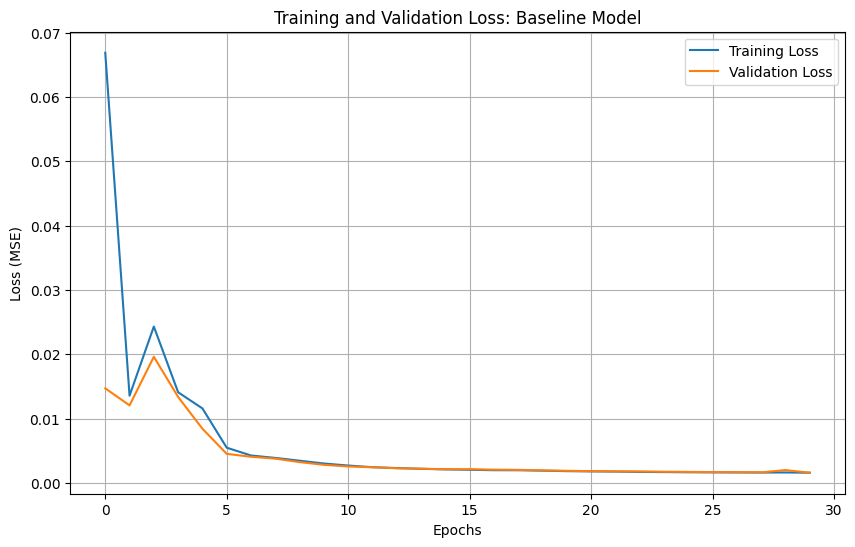

In [50]:
plot_loss_history(history_baseline, 
                  title = "Training and Validation Loss: Baseline Model")

> Based on the final results after 30 epochs, it can be concluded that the baseline model has achieved good convergence. From the *Training and Validation Loss plot*, there is no indication of overfitting, as both the training loss and validation loss curves consistently decrease and converge from the middle to the end of the training.  
> With final values of:
> - **Training Loss**: 0.0016
> - **Validation Loss**: 0.0016
>
> The very small and consistent loss values between the training and validation data indicate that the model is capable of effectively reconstructing images, even for previously unseen data.  
> This serves as an indicator that the model has good generalization ability for the image denoising task.

1/1 [==============================] - 0s 326ms/step


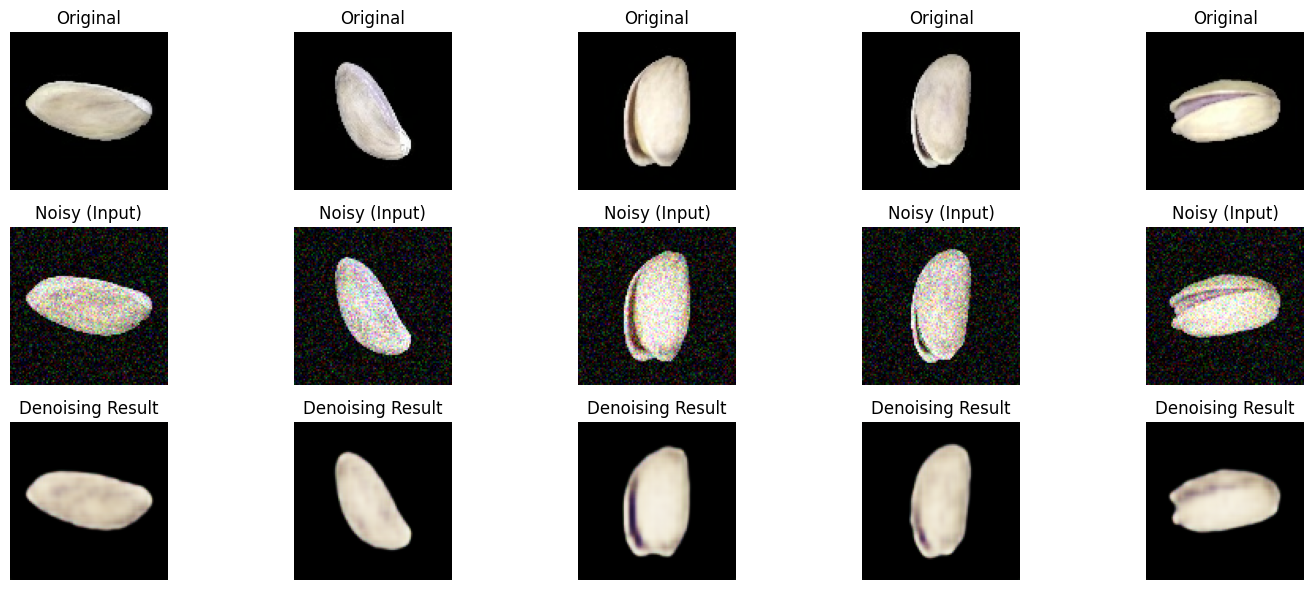

In [51]:
display_result(autoencoder_model, 
               test_ds)

Average SSIM Score: 0.9200429320335388


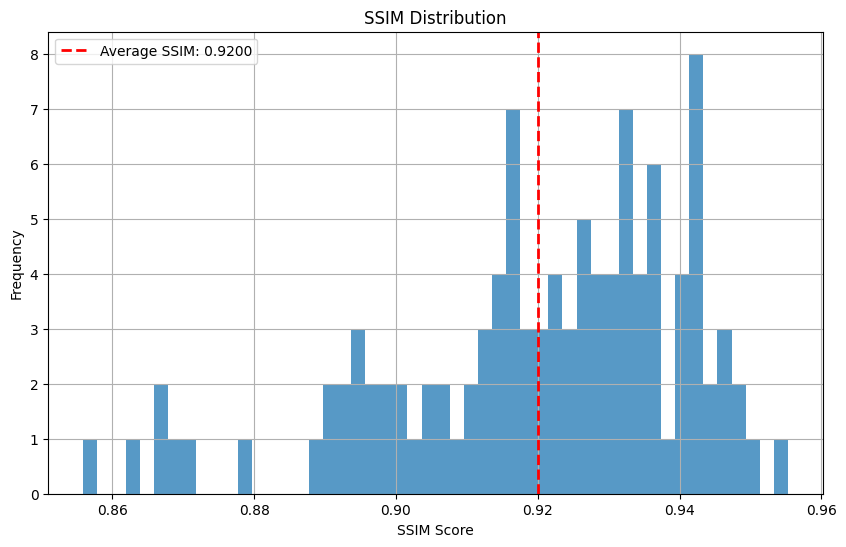

In [52]:
baseline_ssim, all_baseline_ssim = evaluate_ssim(autoencoder_model, 
                                                 test_ds)
plot_ssim(all_baseline_ssim, 
          baseline_ssim)

> Based on the evaluation of the model's performance on the test set using the **SSIM** (Structural Similarity Index) metric, the following value was obtained:
> - **Average SSIM**: 0.920
>
> An **SSIM** value of 0.920 indicates that the image reconstruction results by the model have a very high degree of structural similarity to the original images. An SSIM close to 1 suggests that the structure, contrast, and luminance of the predicted images are almost identical to the noisy input images.  
> However, despite the high **SSIM** score, the visualization of the predicted results still shows that the generated images appear slightly blurry when viewed by the human eye. This indicates that although the global structure has been preserved, fine details in the images have not been fully recovered by the model.  
> Therefore, although the model shows excellent performance in terms of metrics, there is still room for improvement in visual quality, especially to enhance the sharpness of the reconstruction results.

#### MODIFIED MODEL

> To modify the baseline model, I replaced the simple autoencoder architecture with a more complex model designed to resemble a **U-Net** architecture.  
> This change was made by adding deeper *Convolution* layers, *Dropout* for regularization, and skip connections between the encoder and decoder via concatenation.  
> Increasing the number of filters from 32 and 64 (in the baseline model) to 64, 128, and 256 aims to enhance the model's capacity to capture more complex spatial features from the image data.  
> The use of *Dropout* after each convolution block is intended to reduce the risk of overfitting, which is crucial when the model becomes more complex.  
> Furthermore, using *Conv2DTranspose* as an upsampling layer in the decoder provides better learning capability compared to *UpSampling2D*, as it has trainable weights that can be optimized during training.  
> The skip connection strategy (merging features from the encoder to the decoder) is implemented so that the model can retain important spatial information often lost during downsampling, resulting in sharper and more detailed reconstructions.  
> With this approach, the model is expected not only to effectively remove noise from images but also to better preserve the spatial structure and texture of the original images. Compared to the baseline, this model has higher generalization potential and yields sharper, more realistic visual reconstruction results.

In [21]:
def build_modified_autoencoder(input_shape = (224, 224, 3)):
    input_layer = layers.Input(shape = input_shape, name = "input_layer")
    c1 = layers.Conv2D(64, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal", 
                       padding = "same")(input_layer)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    bottleneck = layers.Conv2D(256, (3, 3),
                               activation = "relu",
                               kernel_initializer = "he_normal",
                               padding = "same")(p2)
    bottleneck = layers.Dropout(0.2)(bottleneck)
    bottleneck = layers.Conv2D(256, (3, 3),
                               activation = "relu",
                               kernel_initializer = "he_normal",
                               padding = "same")(bottleneck)

    u3 = layers.Conv2DTranspose(128, (2, 2),
                                strides = (2, 2),
                                padding = "same")(bottleneck)
    u3 = layers.concatenate([u3, c2])
    c3 = layers.Conv2D(128, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(u3)
    c3 = layers.Dropout(0.1)(c3)
    c3 = layers.Conv2D(128, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(c3)

    u4 = layers.Conv2DTranspose(64, (2, 2),
                                strides = (2, 2),
                                padding = "same")(c3)
    u4 = layers.concatenate([u4, c1])
    c4 = layers.Conv2D(64, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(u4)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(64, (3, 3),
                       activation = "relu",
                       kernel_initializer = "he_normal",
                       padding = "same")(c4)

    output_layer = layers.Conv2D(3, (1, 1),
                                 activation = "sigmoid")(c4)
    autoencoder = Model(inputs = input_layer,
                        outputs = output_layer,
                        name = "Modified_Autoencoder")
    
    return autoencoder

In [54]:
modified_autoencoder = build_modified_autoencoder(input_shape = (100, 100, 3))
modified_autoencoder.compile(optimizer = "adam",
                             loss = "mean_squared_error")
modified_autoencoder.summary()

Model: "Modified_Autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 100, 100, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 100, 100, 64  0           ['conv2d_5[0][0]']               
                                )                                              

In [55]:
history_modified = modified_autoencoder.fit(train_ds,
                                            epochs = EPOCHS,
                                            validation_data = val_ds)

Epoch 1/30
27/27 [==============================] - 18s 369ms/step - loss: 0.0317 - val_loss: 0.0032
Epoch 2/30
27/27 [==============================] - 5s 164ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 3/30
27/27 [==============================] - 5s 168ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/30
27/27 [==============================] - 5s 162ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/30
27/27 [==============================] - 5s 166ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/30
27/27 [==============================] - 5s 164ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/30
27/27 [==============================] - 5s 163ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/30
27/27 [==============================] - 5s 163ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/30
27/27 [==============================] - 5s 164ms/step - loss: 0.0010 - val_loss: 9.1542e-04
Epoch 10/30
27/27 [==============================] - 5s 169ms/step - loss: 9.2193e-04 - val_los

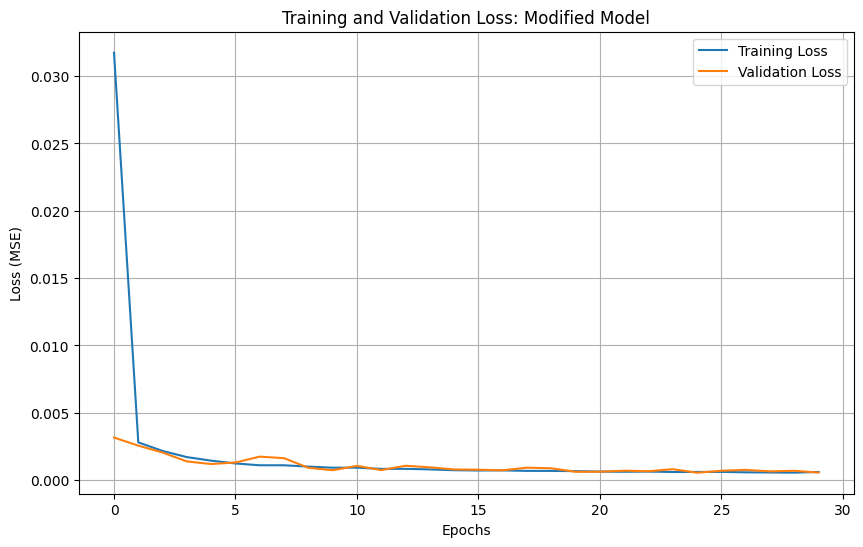

In [56]:
plot_loss_history(history_modified, 
                  title = "Training and Validation Loss: Modified Model")

> Based on the final results after 30 epochs, it can be concluded that the modified model has achieved excellent convergence. From the *Training and Validation Loss plot*, there are no signs of overfitting, as both the training loss and validation loss curves consistently decrease and converge from the middle to the end of the training.  
> With final values of:
> - **Training Loss**: 0.00061
> - **Validation Loss**: 0.00056
>
> The lower loss values compared to the baseline model indicate that this model has a more accurate reconstruction capability and higher precision for noisy inputs. Furthermore, the difference between the training loss and validation loss is very small, which indicates that the model not only fits the training data well but also generalizes effectively to new data.  
> Compared to the baseline model, this model shows a significant performance improvement in both reconstruction accuracy and training stability. Thus, it can be concluded that the architectural modifications had a positive impact on the quality of the denoising results.

1/1 [==============================] - 0s 328ms/step


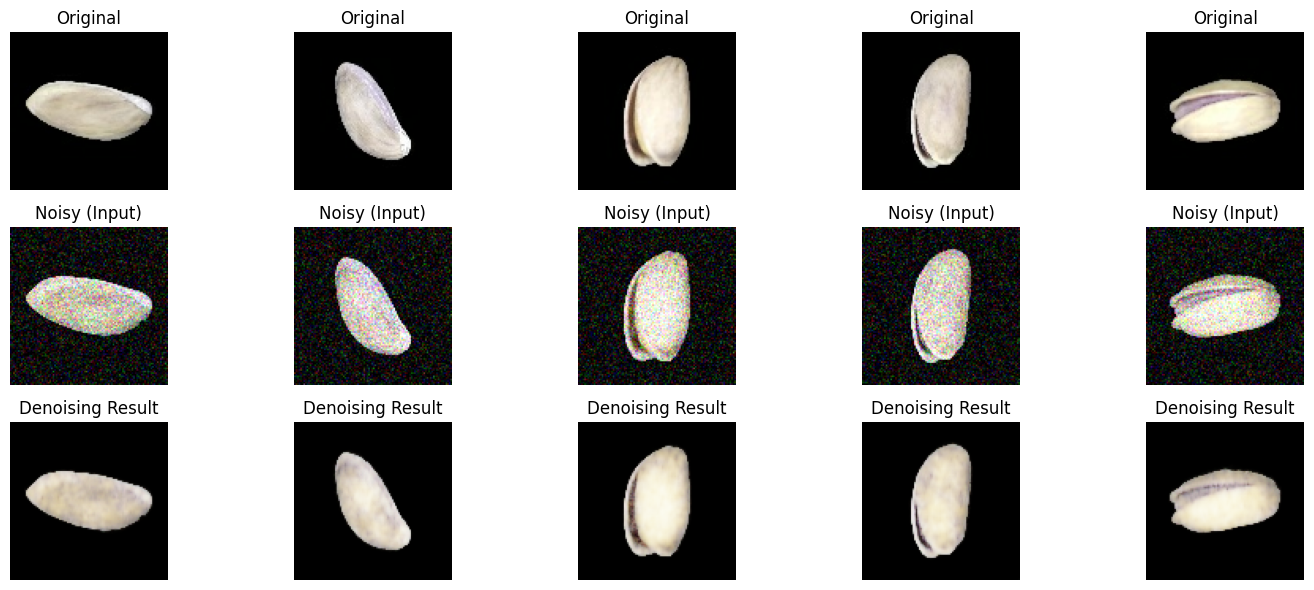

In [57]:
display_result(modified_autoencoder, 
               test_ds)

Average SSIM Score: 0.9499459266662598


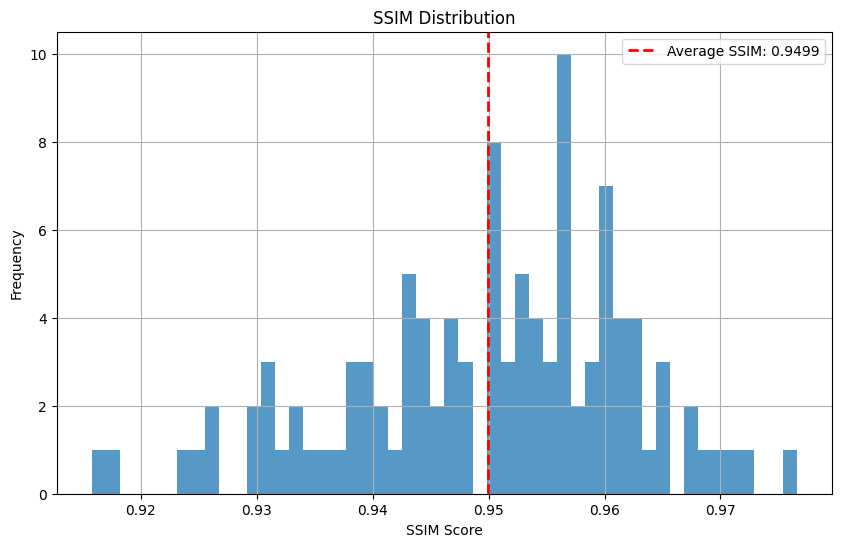

In [65]:
modified_ssim, all_modified_ssim = evaluate_ssim(modified_autoencoder, 
                                                 test_ds)
plot_ssim(all_modified_ssim, 
          modified_ssim)

> Based on the evaluation of the modified autoencoder's performance on the test set using the **SSIM** (Structural Similarity Index) metric, the following value was obtained:
> - **Average SSIM**: 0.950
>
> An **SSIM** value of 0.950 indicates a significant improvement compared to the baseline model, and suggests that this modified model is capable of producing image reconstructions with a very high degree of structural similarity to the original images. This improvement reflects that the structure, contrast, and luminance of the predicted results are increasingly closer to the original noise-free images.  
> However, despite the near-perfect **SSIM** score, the visual results of the reconstructed images still appear quite blurry when subjectively observed by the human eye. This indicates that the model is still not optimal in restoring the fine details of the noisy images, even though their global structure has been well recovered.  
> Thus, although quantitative metrics like **SSIM** show high performance, the visual quality of the reconstruction still has room for improvement, especially in terms of sharpness. This is important to note so that model evaluation remains balanced between quantitative approaches and human visual perception.

#### MODIFIED MODEL 2

> To improve the visual quality of image reconstruction, especially in terms of sharpness and fine detail recovery, I modified the model training process by running the model for a maximum of 200 epochs and adding an *EarlyStopping* callback.  
> The main purpose of increasing the number of epochs to 200 is to provide the model with a longer opportunity to learn image feature representations in greater depth. This is particularly relevant because the modified autoencoder model has a more complex architecture and greater representational capacity compared to the baseline model. With longer training time, the model is expected to reconstruct images more sharply and clearly, and to restore noise down to pixel-level details.  
> To mitigate the risk of overfitting due to the large number of epochs, I used *EarlyStopping* with monitoring on validation loss. This callback automatically stops training if the model does not show performance improvement on the validation data within a certain number of epochs.  
> However, I only activated *EarlyStopping* after at least the first 50 epochs had passed. This is based on the assumption that the model requires a stable and sufficiently long initial training phase to construct effective feature representations. If *EarlyStopping* is activated too early, the model risks stopping before truly reaching its full potential, especially in producing sharp and detailed image reconstructions.

In [22]:
class EarlyStoppingAtMinEpoch(callbacks.EarlyStopping):
    def __init__(self, start_epoch, **kwargs):
        super(EarlyStoppingAtMinEpoch, self).__init__(**kwargs)
        self.start_epoch = start_epoch
    def on_epoch_end(self, epoch, logs = None):
        if epoch >= self.start_epoch:
            super().on_epoch_end(epoch, logs)

MINIMUM_EPOCH = 50
early_stop_with_warmup = EarlyStoppingAtMinEpoch(
    start_epoch = MINIMUM_EPOCH,
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    restore_best_weights = True,
    min_delta = 1e-6
)

In [23]:
modified_autoencoder_2 = build_modified_autoencoder(input_shape = (100, 100, 3))
modified_autoencoder_2.compile(optimizer = "adam",
                               loss = "mean_squared_error")
modified_autoencoder_2.summary()

Model: "Modified_Autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 100, 100, 64  0           ['conv2d[0][0]']                 
                                )                                              

In [24]:
EPOCHS_2 = 200
history_modified_2 = modified_autoencoder_2.fit(train_ds,
                                                epochs = EPOCHS_2,
                                                validation_data = val_ds,
                                                callbacks = [early_stop_with_warmup])

Epoch 1/200
27/27 [==============================] - 36s 497ms/step - loss: 0.0365 - val_loss: 0.0037
Epoch 2/200
27/27 [==============================] - 7s 226ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/200
27/27 [==============================] - 7s 225ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/200
27/27 [==============================] - 7s 225ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/200
27/27 [==============================] - 7s 227ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/200
27/27 [==============================] - 7s 226ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/200
27/27 [==============================] - 7s 227ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/200
27/27 [==============================] - 7s 227ms/step - loss: 0.0010 - val_loss: 8.6439e-04
Epoch 9/200
27/27 [==============================] - 7s 228ms/step - loss: 9.5195e-04 - val_loss: 8.4014e-04
Epoch 10/200
27/27 [==============================] - 7s 228ms/step - loss: 8.

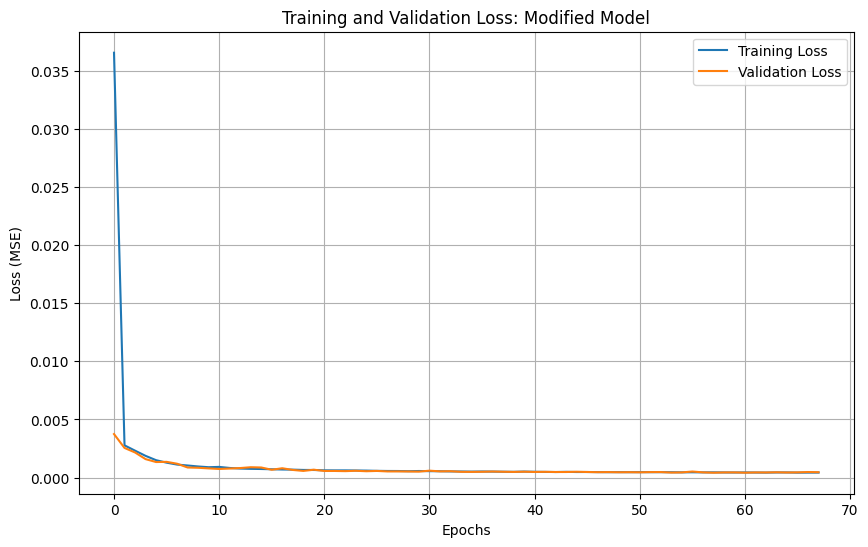

In [25]:
plot_loss_history(history_modified_2, 
                  title = "Training and Validation Loss: Modified Model")

> Based on the final results after 68 epochs, it can be concluded that the modified model has achieved excellent convergence. The model automatically stopped training and reverted to the best epoch, which was epoch 58, with the following final values:
> - **Training Loss**: 4.25e-04
> - **Validation Loss**: 4.58e-04
>
> The very small and consistent loss values between the training and validation data indicate that the modified autoencoder is capable of reconstructing images with high accuracy and without any indication of overfitting.  
> Furthermore, compared to the baseline model, which had a final validation loss of 0.0016, this model shows a significant performance improvement, with a loss reduction of over 60%.  
> This proves that the architectural changes successfully enhanced the model's ability to perform image denoising while maintaining its generalization capability on new data.  
> This insight also confirms that the initial assumption was met: by providing the model with a larger number of epochs and a longer exploration space, the loss can be driven lower. The model successfully utilized the longer training duration to better learn feature representations and ultimately achieved optimal performance at epoch 58.

1/1 [==============================] - 0s 357ms/step


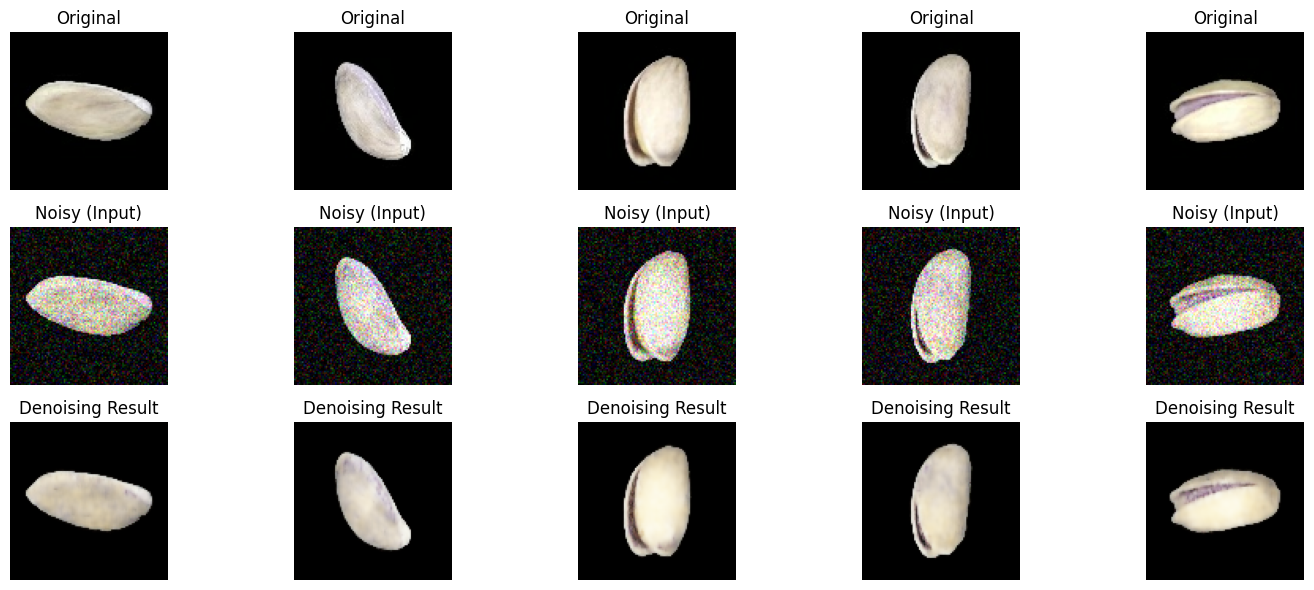

In [26]:
display_result(modified_autoencoder_2, 
               test_ds)

Average SSIM Score: 0.9558942317962646


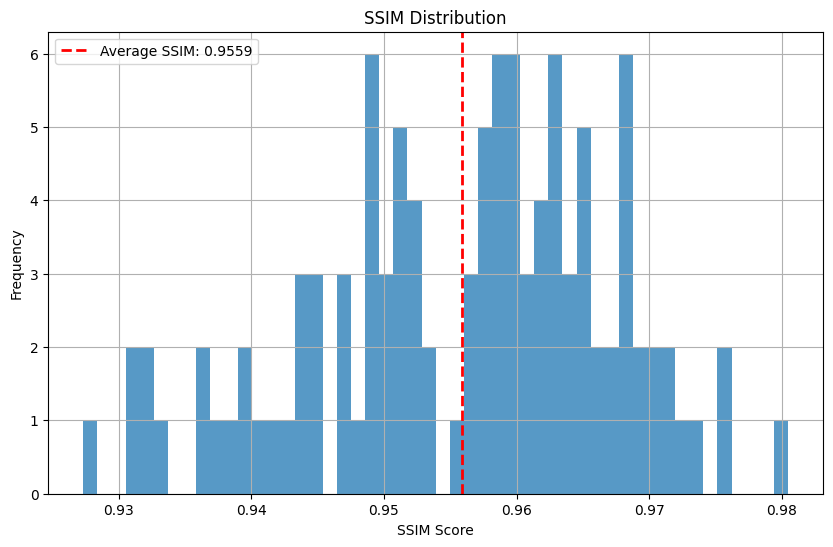

In [27]:
modified_2_ssim, all_modified_2_ssim = evaluate_ssim(modified_autoencoder_2, 
                                                     test_ds)
plot_ssim(all_modified_2_ssim, 
          modified_2_ssim)

> Based on the evaluation of the modified autoencoder 2's performance on the test set using the **SSIM** (Structural Similarity Index) metric, the following value was obtained:
> - **Average SSIM**: 0.956
>
> An **SSIM** value of 0.956 indicates that the reconstructed images have a very high structural similarity to the original noise-free images. An **SSIM** close to 1 demonstrates that the model successfully preserved spatial structure, contrast, and luminance consistently, even after the denoising process.  
> Compared to the two previous models, there's a gradual and consistent performance improvement, with the latest version achieving the highest **SSIM** value to date. This also proves that increasing the number of epochs provides the model with a longer opportunity to learn visual features more deeply, allowing the image structure and content to be restored more accurately.  
> However, despite the very high **SSIM** score, the visual results of the reconstruction still appear slightly blurry when observed subjectively by the human eye. One possible reason for this is that the original images used as references already had a low level of sharpness (somewhat blurry). Since the model learns from these reference images, its reconstruction results reflect the same sharpness, meaning the model cannot fix details that were not present from the beginning.  
> This indicates that even though the **SSIM** is high and the model successfully preserved the global structure, the recovery of fine-grained details remains limited by the visual quality of the training images themselves.  
> Thus, while the model's performance in terms of metrics is already very good, subjective quality improvement can still be achieved, for example, by using sharper reference images or a combination with *Generative Adversarial Networks* (GANs) to enhance visual realism at a detailed level.

### SUMMARY

> Across the three models trained, there was a consistent improvement in the structural similarity between the reconstructed images and the original noise-free images.  
> The increase in **SSIM** values from the baseline model to the modified model indicates that architectural changes and training strategies (such as using *EarlyStopping*) successfully enhanced the model's ability to preserve image structure, contrast, and luminance.  
> However, all models consistently showed limitations in terms of subjective visual quality. The reconstructed images still appeared slightly blurry when observed by the human eye, despite the **SSIM** metric showing excellent results. This suggests that the models generally succeeded in preserving the global structure of the images but were not yet optimal in recovering fine details.